In [1]:
# For operating system interaction
import os
import glob
import datetime
import sys

# For loading .pkl files.
import pickle

# For scientific computing
import numpy as np
import pandas as pd
import scipy.special
import statsmodels.tools.numdiff as smnd # to compute the Hessian matrix

# To compute symbolic expressions
import sympy

# Import custom utilities
import mwc_induction_utils as mwc

# Useful plotting libraries
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
mwc.set_plotting_style()

# Magic function to make matplotlib inline; other style specs must come AFTER
%matplotlib inline

# This enables SVG graphics inline
%config InlineBackend.figure_format = 'svg'

#### Latex Macros
$\newcommand{\foldchange}{\text{fold-change}}$
$\newcommand{\Nns}{N_{NS}}$
$\newcommand{\Ns}{N_{S}}$
$\newcommand{\eai}{\Delta\varepsilon_{AI}}$
$\newcommand{\era}{\Delta\varepsilon_{RA}}$
$\newcommand{\Rs}{\left\langle R_S \right\rangle}$
$\newcommand{\Rns}{\left\langle R_{NS} \right\rangle}$
$\newcommand{\Rtot}{\left\langle R_{\text{tot}} \right\rangle}$
$\newcommand{\Reff}{\left\langle R_{\text{eff}} \right\rangle}$

# Defining the problem

In this notebook we will use a different data set from [Brewster et al. 2014](http://www.sciencedirect.com/science/article/pii/S0092867414002219?via%3Dihub) to infer the value of the free energy difference between the active and inactive state of the repressor $\eai$.

In this paper what the authors measured was the effect of having multiple promoters controlled by the same shared transcription factor. By means of counting plasmid copy numbers and repressor copy numbers they were able to test an expansion of the original simple repression theory presented in [Garcia & Phillips 2011](http://www.pnas.org/content/108/29/12173).

We will show how we can use this data to get a value for the free energy difference between the repressor conformations that is consistent with these measurements.

## The degeneracy of $\eai$ for a single promoter.

The original statistical mechanics formulation of the fold-change equation by Garcia & Phillips 2011 is of the form 
$$
\foldchange = \left(1 + {R \over \Nns}e^{-\beta\tilde\era}  \right)^{-1}.
\tag{1}
$$

This functional form does not exactly match our fold-change equation for the case where the inducer $c=0$
$$
\foldchange = \left(1 + {1 \over 1 + e^{-\beta\eai}} {R \over \Nns}e^{-\beta\era}  \right)^{-1}.
\tag{2}
$$

But the ${1 \over 1 + e^{-\beta\eai}}$ factor could have been simply adsorbed into the energy used by Garcia & Phillips by defining
$$
\tilde\era = \era + \ln\left( 1 + e^{-\beta\eai} \right).
\tag{3}
$$

The problem is that the values for the effective parameter $\tilde\era$ parameter reported by Garcia and Phillips cannot be directly used with Eq. 1 and 2 to deconvolve both parameters $\era$ and $\eai$. In other words Eq. 3 shows an undetermined system with more variables than equations, such that from these we cannot determine the "real" binding energy and the free energy difference simultaneously.

## The use of multiple promoters data to deconvolve $\era$ and $\eai$

Here we propose using data for multiple plasmid data to tackle this issue with the undetermined system. As we will show when accounting for multiple promoters the model predicts an inflection when plotting fold-change vs. number of repressors when the number of **active repressors** is comparable with the number of available promoters. To show this let's define the equation to account for multiple promoters.

### Define function to compute the fold-change for multiple promoters.

The original theory used by Brewster et al. uses the canonical ensemble that requires tracking of each of the available repressors in the cell. In a further paper [Weinert et al.](https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.113.258101) used the grand canonical ensemble to apply the constrains on transcription factor copy number via the fugacity (or equivalently the chemical potential) of the repressor. For the purpose of our analysis we will use this second derivation of the theory as it simplifies the math enormously. For a detailed derivation of this formulation we point the reader to the original paper.

Using the grand canonical ensemble we have that the fold-change is given by
$$
\foldchange = {1 \over 1 + \lambda_r e^{-\beta\era}},
\tag{4}
$$
where we introduce $\lambda_r$ as the fugacity of the repressor. In this formulation we explicitly account for subsystems in contact with an energy and particle reservoir. In this case our two subsystems are all of the $\Ns$ promoter binding sites and the $\Nns$ non-specific binding sites. As shown in Weinert et al. 2014 the average number of repressors adsorbed into the promoters $\Rs$ is given by
$$
\Rs = N_S {\lambda_r e^{-\beta\era} \over 1 + \lambda_r e^{-\beta\era}}.
\tag{5}
$$
Equivalently the number of repressors adsorbed into the non-specific binding sites is given by
$$
\Rns = \Nns {\lambda_r \over 1 + \lambda_r}.
\tag{6}
$$

These two subsystems are connected via the constraint that the mean repressor copy number $\Rtot$ was experimentally determined and the pool of these repressors is shared among them. That means that it must hold true that
$$
\Rtot = \Rs +  \Rns.
\tag{7}
$$

As we will show if we consider not the total number of repressors determined experimentally $\Rtot$ but the number of repressors that are active in the absence of inducer $\Reff \equiv p_{act}(c=0)\cdot \Rtot$ we can use this formulation along with Brewster et al. data to determine the free energy difference between repressor conformations $\eai$.

### Finding root of polynomial equation to determine the fugacity $\lambda_r$

For Eq. 4 to predict the fold-change we must find the value of the fugacity $\lambda_r$ given the average number of repressors $\Rtot$, the number of promoters $\Ns$, the number of non-specific binding sites $\Nns$ and both the binding energy $\era$ and the free energy difference between conformations $\eai$. This implies that we need to solve Eq. 7 for $\lambda_r$ but considering $\Reff$ rather than $\Rtot$. For this we will use the symbolic computation package `sympy`.

First we define the variables needed for this problem along with Eq. 5 and 6. For this we will consider that Eq. 3 relates the effective binding energy $\tilde\era$ as reported by Garcia & Phillips and the fraction of active repressors. That means that we will use the energy
$$
\era = \tilde\era - \ln\left(1 + e^{-\beta\eai} \right)
\tag{8}
$$
as the energy that appears in both Eq. 4 and 5.

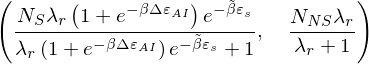

In [2]:
# print outputs in LaTeX
sympy.init_printing(use_unicode=True)

# Define symbolic variables for sympy
Ns, lam, es, Nns = \
sympy.symbols('N_S \\lambda_r \\tilde\\beta\\varepsilon_s N_{{NS}}')
eAI = sympy.symbols('\\beta\\Delta\\varepsilon_{{AI}}')
R = sympy.symbols('\\left\\langle{{R}}\\right\\rangle')

# compute the adjusted energy
energy = es - sympy.log(1 + sympy.exp(-eAI))

# Define the equations for the average repressor occupancy of both
# the promoters and the non-specific binding sites
Rs = Ns * lam * sympy.exp(-energy) / (1 + lam * sympy.exp(-energy))
Rns = Nns * lam / (1 + lam)
Rs, Rns

Again, the left equation $\Rs$ differs from Eq. 5 because we substitute this energy with Eq. 8.

Now we define Eq. 7

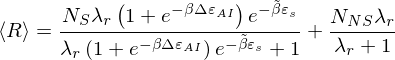

In [3]:
# Compute equation for total number of repressors and average occupancy
Rtot = sympy.Eq(R, Rs + Rns)
Rtot

And now we solve for the fugacity $\lambda_r$ keeping only the positive root of the 2nd degree polynomial.

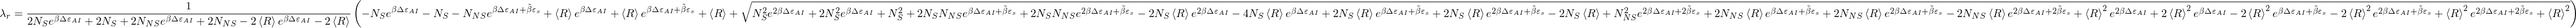

In [4]:
# Solve equation for lambda.
# Keep second entry since is the strictly positive root
lam_sol = sympy.solve(Rtot, lam)[1]
sympy.Eq(lam, lam_sol)

Finally we generate a "`lambdify`" function that will allow us to evaluate this root numerically.

In [5]:
# Define lambdify function
lam_num = sympy.lambdify([R, es, eAI, Ns, Nns], lam_sol, 'numpy')

# Turn off fancy Latex printing
sympy.init_printing(pretty_print=False) # print outputs in LaTeX

### Define fold-change function

Now that we have the equation to find numerically the value for the fugacity we can define a function to compute the fold-change. For this function given a value of repressors $\Rtot$ and a free energy difference between repressor conformations $\eai$ the effective number of repressors $\Reff$ will be computed as
$$
\Reff = {1 \over 1 + e^{-\beta\eai}} \cdot \Rtot.
\tag{9}
$$
This will be the value that is fed to the fugacity function. In this way we explicitly account for the fact that only the repressors in the active state can be adsorbed into one of the subsystems.

In [6]:
def fold_change(R, es, eAI, Ns, Nns=4.6E6):
    '''
    Computes the fold-change in gene expression for multiple simple repression
    promoters using the Grand canonical formulation in the absence of inducer.
    Parameters
    ----------
    R : array-like.
        Total number of repressors per cell.
    es : array-like.
        Binding energy of the repressor to the operator as determined by
        Garcia and Phillips for single promoter constructs.
    eAI : array-like.
        Energy difference between active and inactive states of the repressor.
    Ns : array-like.
        Number of promoters per cell.
    Nns : float.
        Number of non-specific binding sites
    
    Returns
    -------
    Theoretical fold-change
    '''
    # Compute the effective number of repressors given a count of total
    # repressor count per cell and a free energy difference between 
    # repressor conformations.
    Reff = R * 1 / (1 + np.exp(-eAI))
    
    # Find the fugacity lambda_r given the parameters
    fugacity = lam_num(Reff, es, eAI, Ns, Nns)
    
    # Obtain the adjusted energy Given an "effective energy" as reprted by
    # Garcia & Phillips and a free energy difference between conformations.
    energy = es - np.log(1 + np.exp(-eAI))
    
    # Compute and return the theoretical fold change.
    return 1 / (1 + fugacity * np.exp(-energy))

Let's now test the plot by using some arbitrary parameters.

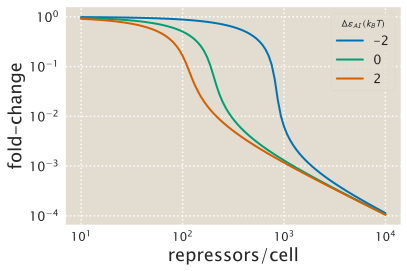

In [7]:
R_array = np.logspace(1, 4, 100) # repressors per cell
es = -15.3 # kBT
eAI = [-2, 0, 2] # kBT
Ns = 100 # mean plasmid copy number

for eai in eAI:
    # Compute theoretical fold-change
    fc_theory = fold_change(R_array, es, eai, Ns)

    # Plot theoretical prediciton on log-log
    plt.loglog(R_array, fc_theory, label=str(eai))

plt.legend(title='$\Delta \epsilon_{AI} \; (k_BT)$')
# Label axis
plt.xlabel('repressors/cell')
plt.ylabel('fold-change')

As we can see as we vary the $\eai$ parameter, the inflection point of the curve changes to the point where $\Reff \approx \Ns$.

# Using experimental data to fit $\eai$

We are now ready to use the data from Brewster et al. 2014. For simplicity in this analysis we will ignore the error bars on both the number of repressors and fold-change.

In [8]:
df = pd.read_csv('../../data/tidy_Garcia_Brewster.csv')
df.head()

,paper,operator,repressors,fold_change,Ns,Ns_energy,Nc,Nc_energy
0,Cell_2014,O1,3.570,1.0460,64,-15.3,0,0.0
1,Cell_2014,O1,4.751,0.9676,64,-15.3,0,0.0
2,Cell_2014,O1,5.478,1.0230,64,-15.3,0,0.0
3,Cell_2014,O1,6.545,1.1680,64,-15.3,0,0.0
4,Cell_2014,O1,7.211,0.8455,64,-15.3,0,0.0


Let's now look at the raw data for the case when there are $\Ns = \{10, 52, 64 \}$ promoters per cell in plasmid.

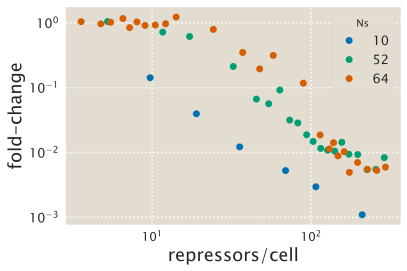

In [9]:
# Group by number of promoteres per cell
df_group = df[(df.Ns > 1) & (df.Nc == 0)].groupby('Ns')

# Plot raw data for all independent data sets
for group, data in df_group:
    plt.loglog(data.repressors, data.fold_change, linewidth=0, marker='o',
               label=str(group))
    
# Label axis
plt.xlabel('repressors/cell')
plt.ylabel('fold-change')
plt.legend(title=r'Ns')

## Code the marginalized posterior $P(\Delta\varepsilon_{AI}\mid D)$

We will now use a Bayesian approach to compute the probability distribution of the parameter $\eai$ given our experimental data $D$. For this we first write Bayes theorem as
$$
P(\eai \mid D) \propto P(D \mid \eai)P(\eai),
\tag{10}
$$
where we ignore the normalization constant. For the first term on the right hand side - the likelihood $P(D \mid \eai)$ - we will assume a Gaussian distribution for the deviations from the theoretical model, i.e.
$$
P(D \mid \eai, \sigma) \propto \prod_{i \in D} {1 \over \sigma}
\exp\left[- {\left(\foldchange_{\text{exp}}^{(i)} - 
                   \foldchange_{\text{theory}}^{(i)}\right)^2
\over 2 \sigma^2 }\right],
\tag{11}
$$
where $\sigma$ is a new nuisance parameter associated with the selection of this functional form of the likelihood and $\foldchange_{\text{exp}}$ and $\foldchange_{\text{theory}}$ represent the experimental and theoretical fold-change, respectively. Note that we included this parameter on the left hand side of the equation since we must treat it for now as any other parameter we wanted to infer. At the end of the analysis we will integrate it out in order to get the distribution of the parameter we are interested in. Note also that we wrote the product $\prod_{i\in D}$ to explicitly assume that each datum is independent of the others.

We assign a uniform prior to $\eai$ since in principle the free energy could take either positive or negative values. For the new nuisance parameter $\sigma$ we assign a Jeffreys' prior. This gives us a prior of the form
$$
P(\eai, \sigma) \propto {1 \over \eai{_\max} - \eai{_\min}} \cdot {1 \over \sigma}.
\tag{12}
$$

Putting together Eq. 11 and 12 gives the final form of the likelihood. To remove the nuisance parameter we integrate it out as
$$
P(\eai \mid D) = \int d\sigma \; P(\eai, \sigma \mid D).
\tag{13}
$$
For the case of a uniform prior and a Gaussian likelihood this integral has a closed form solution. Here we quote the result, a student-t distribution of the form
$$
P(\eai) \propto \left[\sum_{i\in D} 
        \left(\foldchange_{\text{exp}}^{(i)} - 
                   \foldchange_{\text{theory}}^{(i)}\right)^2\right]
                   ^{-{n\over 2}},
\tag{14}
$$
where $n \equiv \vert D \vert$ is the number of data points.

For theoretical and numerical reasons is better to work with the log of the posterior, so we will code the log-posterior rather than Eq. 14.

In [10]:
def log_post(fc_exp, R, es, eAI, Ns, Nns=4.6E6):
    '''
    Compute the unnormalized student-t distribution given some experimental 
    fold-changes for a multiple promoter architecture.
    
    Parameters
    ----------
    fc_exp : array-like.
        Experimental gene-expression fold-change
    R : array-like.
        Total number of repressors per cell.
    es : array-like.
        Binding energy of the repressor to the operator as determined by
        Garcia and Phillips for single promoter constructs.
    eAI : array-like.
        Energy difference between active and inactive states of the repressor.
    Ns : array-like.
        Number of promoters per cell.
    Nns : float.
        Number of non-specific binding sites
    
    Returns
    -------
    Unormalized log posterior.
    '''
    # Compute the theoretical fold-change
    fc_theory = fold_change(R, es, eAI, Ns, Nns)
    
    # compute the un-normalized log-posterior
    return - len(fc_exp) / 2 * np.sum((fc_exp - fc_theory)**2)

With this function we now evaluate the posterior distribution for an array ov values of $\eai$.

In [11]:
# Evaluate log_posterior in a grid of epsilon energies
eAI_array = np.linspace(-5, 10, 200) # kBT

# initialize log_posterior array
lnp = np.zeros_like(eAI_array)

# Use only the data for multiple promoters in plasmid.
df_fit = df[(df.Ns > 1) & (df.Nc == 0)]

# Evaluate log posterior in a for-loop
for i, eAI in enumerate(eAI_array):
    lnp[i] = log_post(df_fit.fold_change, df_fit.repressors, 
                      df_fit.Ns_energy, eAI, df_fit.Ns)


# To make the unnormalized posterior scale better
lnp -= np.max(lnp)

Let's now look at the posterior distribution $P(\eai \mid D)$

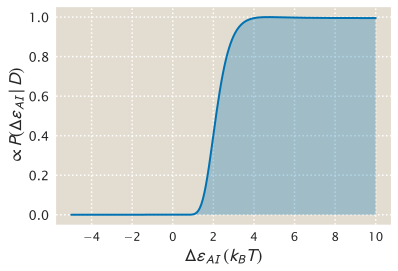

In [12]:
plt.plot(eAI_array, np.exp(lnp))
plt.xlabel(r'$\Delta\varepsilon_{AI}\; (k_BT)$')
plt.fill_between(eAI_array, np.exp(lnp), alpha=0.3)
plt.ylabel(r'$\propto P(\Delta\varepsilon_{AI} \mid D)$')

The strange form of the posterior distribution shows that basically any value > $4.5 k_BT$ would give the exact same result. What this indicates is that basically in order for the model to be in agreement with Brewster et al. data, almost 100% of the repressors mus be active. $4.5\; k_BT$ gives roughly $1/100$ inactive repressors. Distinguishing between this and $1/10^3$ or even smaller fractions is not possible from this indirect inferences, but also would not change our results.

Therefore for this work we used this value of $\eai = 4.5\;k_BT$ as the value for the free energy difference between the active and inactive state of the repressor.

Let's look at how well this value predicts Brewster et al. data.

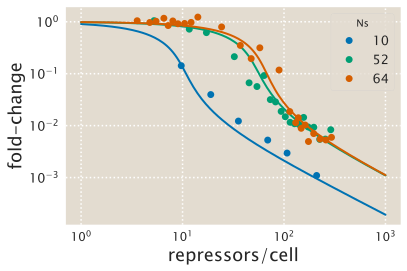

In [13]:
R_array = np.logspace(0, 3, 150) # repressors per cell
eAI = 4.5 # kBT

# Plot raw data
df_group = df[(df.Ns > 1) & (df.Nc == 0)].groupby('Ns')

colors = sns.color_palette('colorblind', n_colors=len(df_group))
i = 0 # initialize counter
# Plot raw data for all independent data sets
for group, data in df_group:
    # Compute theoretical fold change
    es = data.Ns_energy.unique()[0]
    Ns = group
    fc_theory = fold_change(R_array, es, eAI, Ns)
    
    # Plot theoretical prediction for 4.5 kBT
    plt.loglog(R_array, fc_theory, label='', color=colors[i])
    plt.loglog(data.repressors, data.fold_change, linewidth=0, marker='o',
               label=str(group), color=colors[i])
    i += 1
    
# Label axis
plt.xlabel('repressors/cell')
plt.ylabel('fold-change')
plt.legend(title=r'Ns')

# Comparison with literature values.

From a similar setting [Daber et al.](http://www.sciencedirect.com/science/article/pii/S0022283609009036?via%3Dihub) inferred a different value for this free energy difference. In their work they used a plasmid based system in which they titrated IPTG and measure the expression of a GFP reporter. In their system there was no direct count of the repressor copy number nor the plasmid copy number compared to our system. Nevertheless using a non-linear regression they report a value of $\eai = - \ln 2\; k_BT$. We can use this value and see how well it predict Brewster et al. data.

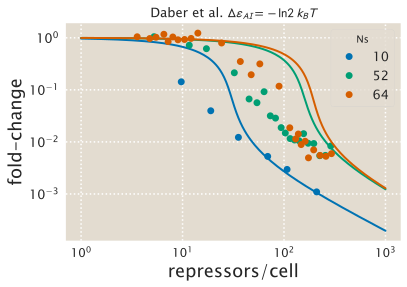

In [14]:
R_array = np.logspace(0, 3, 150) # repressors per cell
eAI = -np.log(2) # kBT

# Plot raw data
df_group = df[(df.Ns > 1) & (df.Nc == 0)].groupby('Ns')

colors = sns.color_palette('colorblind', n_colors=len(df_group))
i = 0 # initialize counter
# Plot raw data for all independent data sets
for group, data in df_group:
    # Compute theoretical fold change
    es = data.Ns_energy.unique()[0]
    Ns = group
    fc_theory = fold_change(R_array, es, eAI, Ns)
    
    # Plot theoretical prediction for 4.5 kBT
    plt.loglog(R_array, fc_theory, label='', color=colors[i])
    plt.loglog(data.repressors, data.fold_change, linewidth=0, marker='o',
               label=str(group), color=colors[i])
    i += 1
    
# Label axis
plt.xlabel('repressors/cell')
plt.ylabel('fold-change')
plt.title(r'Daber et al. $\Delta\epsilon_{AI} = -\ln 2 \; k_BT$', fontsize=13)
plt.legend(title=r'Ns')

## Origin of the discrepancy.

We asked ourselves what is the origin of this discrepancy between parameters. To explore this we digitized Daber et al. data and followed their methodology to infer the parameters, but this time applying Bayesian methods to look at the complete posterior distribution of parameters.

In their paper Daber et al. used lacI heterodimers in which they were able to inactivate 1 or 2 of the inducer binding pockets. With this data they use the leakiness given by our equation 2 and saturation given by
$$
\foldchange(c\rightarrow \infty) = 
\left(1 + {1 \over 1 + e^{-\beta\eai}\left( {K_A \over K_I} \right)^n} 
{R \over \Nns}e^{-\beta\era}  \right)^{-1},
\tag{15}
$$
where $n \in {0, 1, 2}$ indicates the number of functional IPTG binding sites in the dimer to infer the parameter. Daber et al define the quantity
$$
y_n \equiv {1 \over \foldchange} - 1 = {1 \over 1 + 
e^{-\beta\eai}\left({K_A} \over K_I \right)^n}
{R \over \Nns} e^{-\beta\era}.
\tag{16}
$$

Taking the ratio of $y_x / y_0$, where $x \in \{1, 2\}$ we find
$$
{y_x \over y_0} = {1 + e^{-\beta\eai} \over 1 + 
e^{-\beta\eai}\left({K_A} \over K_I \right)^x}.
\tag{17}
$$
So by computing this ratio experimentally and fitting this non-linear equation one can get at the value of two parameters: the free energy difference between repressor conformations, and the ratio of the dissociation constants $K_A / K_I$. For numerical convenience we can take this ratio of dissociation constants and re-write it as
$$
{y_x \over y_0} = {1 + e^{-\beta\eai} \over 1 + 
e^{-\beta\eai}e^{x \ln{K_A \over KI}}}.
\tag{18}
$$
All we are doing by making this transformation is giving a uniform prior to the log of the ratio, so Eq. 17 and 18 are completely equivalent.

We can then use the exact same approach as the one used to derive Eq. 14 and write down a posterior probability for both parameters as
$$
P\left(\eai, \ln \left( {K_A \over K_I} \right) \right) \propto
\left[\sum_{i\in D} \left( \left( {y_x \over y_0}\right)^{(i)}_{\exp} -
       \left( {y_x \over y_0}\right)^{(i)}_{\text{theory}} \right) 
       \right]^{-{n\over 2}}.
\tag{19}
$$

Having written the posterior let's code it up and apply it on Daber et al. data

First we will define a function to compute the theoretical ratio ${y_x \over y_0}$.

In [124]:
def y_ratio(eai, logKa_Ki, n=2):
    '''
    Computes the ratio of saturation to leakiness as defined by Daber and
    Lewis.
    Parameters
    ----------
    e_ai : array-like.
        Energy difference between the active and inactive conformation of 
        the repressor
    logKa_Ki : array-like/
        The log of the dissociation constants of the inducer binding into 
        the active and inactive conformation of the repressor
    '''
    return (1 + np.exp(-eai)) / (1 + np.exp(-eai) * 10**(n * logKa_Ki))

Now we define a function to compute the log posterior.

In [125]:
def log_post_daber(param, n2, n1):
    '''
    Computes the log posterior of the two parameters eai and ei_ea assuming
    a Gaussian likelihood and uniform priors for both parameters given the 
    experimentally determined values of leakiness and saturation.
    Parameters
    ----------
    param : array-like.
        Array containing both parameters:
        param[0] = eai
        param[1] = logKa_Ki
    n2 : array-like. 2 entries
        n2[0] = saturation for dimer with 2 active binding sites
        n2[1] = leakiness for dimer with 2 active binding sites
    n1 : array-like. 2 entries
        n1[0] = saturation for dimer with 1 active binding sites
        n1[1] = leakiness for dimer with 1 active binding sites
    '''
    # Unpack parameters
    eai = param[0]
    logKa_Ki = param[1]
    
    # Compute parameters for n = 2 active binding sites
    y_saturation = 1 / n2[0] - 1
    y_leakiness = 1 / n2[1] - 1
    y_ratio_exp_n2 = y_saturation / y_leakiness
    
    # Compute the theoretical y_ratio
    y_ratio_thry_n2 = y_ratio(eai, logKa_Ki, 2)
    
    # Compute parameters for n = 2 active binding sites
    y_saturation = 1 / n1[0] - 1
    y_leakiness = 1 / n1[1] - 1
    y_ratio_exp_n1 = y_saturation / y_leakiness
    
    # Compute the theoretical y_ratio
    y_ratio_thry_n1 = y_ratio(eai, logKa_Ki, 1)
    
    y_ratio_exp = np.array([y_ratio_exp_n2, y_ratio_exp_n1]).flatten()
    y_ratio_thry = np.array([y_ratio_thry_n2, y_ratio_thry_n1]).flatten()
    
    # return the log posterior
    return -np.size(y_ratio_exp) / 2 * \
           np.log(np.sum((y_ratio_exp - y_ratio_thry)**2))
    
    
def resid(param, n2, n1):
    '''
    Computes the residuals between theoretical and experimental values. This
    function is used in the optimization algorithm to find the most likely
    parameters.
    Parameters
    ----------
    param : array-like.
        Array containing both parameters:
        param[0] = eai
        param[1] = logKa_Ki
    n2 : array-like. 2 entries
        n2[0] = saturation for dimer with 2 active binding sites
        n2[1] = leakiness for dimer with 2 active binding sites
    n1 : array-like. 2 entries
        n1[0] = saturation for dimer with 1 active binding sites
        n1[1] = leakiness for dimer with 1 active binding sites
    '''
    # Unpack parameters
    eai = param[0]
    logKa_Ki = param[1]
    
    # Compute parameters for n = 2 active binding sites
    y_saturation = 1 / n2[0] - 1
    y_leakiness = 1 / n2[1] - 1
    y_ratio_exp_n2 = y_saturation / y_leakiness
    
    # Compute the theoretical y_ratio
    y_ratio_thry_n2 = y_ratio(eai, logKa_Ki, 2)
    
    # Compute parameters for n = 2 active binding sites
    y_saturation = 1 / n1[0] - 1
    y_leakiness = 1 / n1[1] - 1
    y_ratio_exp_n1 = y_saturation / y_leakiness
    
    # Compute the theoretical y_ratio
    y_ratio_thry_n1 = y_ratio(eai, logKa_Ki, 1)
    
    y_ratio_exp = np.array([y_ratio_exp_n2, y_ratio_exp_n1]).flatten()
    y_ratio_thry = np.array([y_ratio_thry_n2, y_ratio_thry_n1]).flatten()
    
    return y_ratio_exp - y_ratio_thry

Now we read Daber et al. digitized data.

In [97]:
df_daber = pd.read_csv('../../data/Daber_Lewis_OneIsNotEnough.csv')
df_daber.head()

,data_set,IPTG_mM,fold_change
0,tetramer,0.000100,0.031737
1,tetramer,0.000500,0.037126
2,tetramer,0.001000,0.040719
3,tetramer,0.004910,0.143114
4,tetramer,0.009815,0.319162


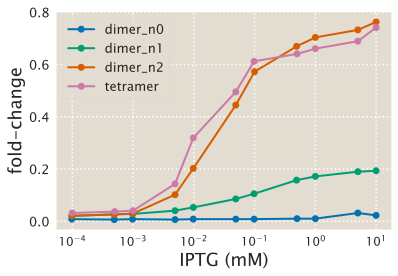

In [98]:
# Group by type of data set
df_group = df_daber.groupby('data_set')

for group, data in df_group:
    plt.plot(data.IPTG_mM, data.fold_change, marker='o',
            label=group)
plt.xscale('log')
plt.xlabel('IPTG (mM)')
plt.ylabel('fold-change')
plt.legend(loc=0)

With this data in hand we evaluate the posterior distribution on a 2D grid of parameter values. 

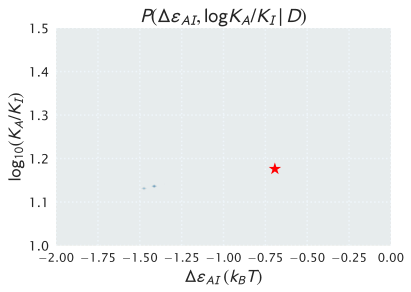

In [129]:
# Parameter values to plot
e_ai = np.linspace(-2, 0, 100)
logKa_Ki = np.linspace(1, 1.5, 100)

# make a grid to plot
eai_grid, logKa_Ki_grid = np.meshgrid(e_ai, logKa_Ki)

# Extract data from n=1 and n=2
df_n2 = df_daber[df_daber.data_set == 'dimer_n2']
df_n1 = df_daber[df_daber.data_set == 'dimer_n1']
df_n0 = df_daber[df_daber.data_set == 'dimer_n0']

n2 = np.array([df_n2[df_n2.IPTG_mM == df_n2.IPTG_mM.max()].fold_change.values,\
      df_n2[df_n2.IPTG_mM == df_n2.IPTG_mM.min()].fold_change.values])

n1 = np.array([df_n1[df_n1.IPTG_mM == df_n1.IPTG_mM.max()].fold_change.values,\
      df_n1[df_n1.IPTG_mM == df_n1.IPTG_mM.min()].fold_change.values])

# compute the log posterior
log_posterior = np.empty_like(eai_grid)
for i in range(len(e_ai)):
    for j in range(len(logKa_Ki)):
        log_posterior[i, j] = \
        log_post_daber([eai_grid[i, j], logKa_Ki_grid[i, j]], n2, n1)
                       

# Get things to scale better
log_posterior -= log_posterior.max()

# plot the results
plt.figure()
plt.contourf(eai_grid, logKa_Ki_grid, np.exp(log_posterior), alpha=0.7,
             cmap=plt.cm.Blues)

# Define the values reported in the paper
eai_daber = -np.log(2)
logKa_Ki_daber = np.log10(15)
# Indicate the fit they obtained
plt.plot(eai_daber, logKa_Ki_daber, marker='*', markersize=13,
         color='red')

# Label the axis
plt.xlabel(r'$\Delta\varepsilon_{AI}\; (k_BT)$')
plt.ylabel(r'$\log_{10}(K_A / K_I)$')
plt.title('$P(\Delta\epsilon_{AI}, \log K_A/K_I \mid D)$')

We can see that the posterior distribution is completely degenerate. This means that from this method there is an entire family of parameter combinations that will lead to similar results. So the initial guess for a minimizer routine would led to different results every time.

This analysis shows that the method used by Daber et al. does not lead to a robust value for the free energy difference between repressor conformations and that is why there is a disagreement between their reported value and our inferred parameter.

Given that in our methodology we use data in which the repressor and plasmid copy number were measured independently we can get at a better estimate of this parameter such that it is consistent across all of our different datasets on simple repression.

# Reconciliating parameters.

We now apply our fit value of $\eai = 4.5\; k_BT$ to Daber et al. data and find the probability distribution of the ratio of dissociation constants.

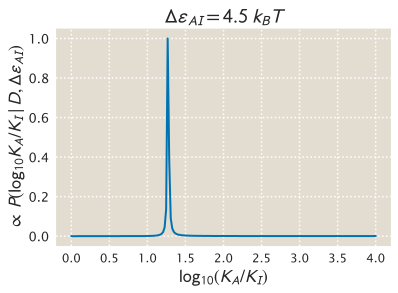

In [146]:
# Parameter values to plot
e_ai = -np.log10(2) #kBT
logKa_Ki = np.linspace(0, 4, 200)

# Extract data from n=1 and n=2
df_n2 = df_daber[df_daber.data_set == 'dimer_n2']
df_n1 = df_daber[df_daber.data_set == 'dimer_n1']
df_n0 = df_daber[df_daber.data_set == 'dimer_n0']

n2 = np.array([df_n2[df_n2.IPTG_mM == df_n2.IPTG_mM.max()].fold_change.values,\
      df_n2[df_n2.IPTG_mM == df_n2.IPTG_mM.min()].fold_change.values]).flatten()
n1 = np.array([df_n1[df_n1.IPTG_mM == df_n1.IPTG_mM.max()].fold_change.values,\
      df_n1[df_n1.IPTG_mM == df_n1.IPTG_mM.min()].fold_change.values]).flatten()

# compute the log posterior
log_posterior = np.empty_like(logKa_Ki)
for j in range(len(logKa_Ki)):
    log_posterior[j] = \
    log_post_daber([e_ai, logKa_Ki[j]], n2, n1)
                       

# Get things to scale better
log_posterior -= log_posterior.max()

# plot the results
plt.figure()
plt.plot(logKa_Ki, np.exp(log_posterior))

# Label the axis
plt.xlabel(r'$\log_{10} (K_A / K_I)$')
plt.ylabel(r'$\propto\;P(\log_{10} K_A/K_I \mid D, \Delta\epsilon_{AI})$')
plt.title('$\Delta\epsilon_{AI} = 4.5\; k_BT$')

In [140]:
resid_logKaKi = lambda logKaKi, n2, n1 : resid([4.5, logKaKi], n2, n1)

p0 = 7
popt, _ = scipy.optimize.leastsq(resid_logKaKi, p0, args=(n2, n1))
print('MAP Ka/Ki : {}'.format(10**popt))

MAP Ka/Ki : [ 929.33754678]


In [143]:
# Define fractional errors
error = np.linspace(-0.4, 0.4, 100)
logKaKi_map = np.zeros_like(error)

p0 = 5
for i, e in enumerate(error):
    n2_new = np.array([n2[0], n2[1] * (1 + e)])
    n1_new = np.array([n1[0], n1[1] * (1 + e)])
    popt, _ = scipy.optimize.leastsq(resid_logKaKi, p0, args=(n2_new, n1_new))
    logKaKi_map[i] = popt

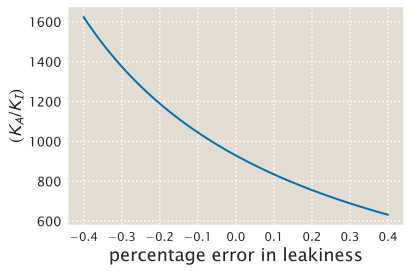

In [144]:
plt.plot(error, 10**(logKaKi_map))
plt.xlabel('percentage error in leakiness')
plt.ylabel('$(K_A / K_I)$')

# Using his parameters.

In [75]:
def fc_daber(c, r, Ka, Ki, L, n=2):
    pact = (1 + c / Ka)**n / ((1 + c / Ka)**n + L * (1 + c / Ki)**n)
    return (1 + r * pact)**-1

c = np.logspace(-4, 1, 100)
r = 150
L = 2
Ka = 4 * 15 / 1E3
Ki = 4 / 1E3

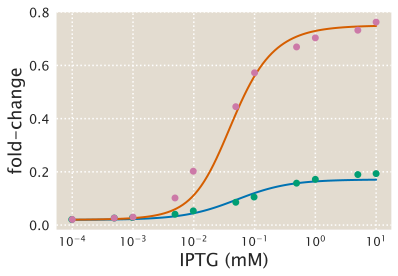

In [76]:
# Group by type of data set

df_fit = df_daber[(df_daber.data_set == 'dimer_n1') |\
                (df_daber.data_set == 'dimer_n2')]

df_group = df_fit.groupby('data_set')

for group, data in df_group:
    if group == 'dimer_n1':
        n=1
    else:
        n=2
    fc_theory = fc_daber(c, r, Ka, Ki, L, n=n)
    plt.plot(c, fc_theory)
    plt.plot(data.IPTG_mM, data.fold_change, marker='o',
             linewidth=0)
plt.xscale('log')
plt.xlabel('IPTG (mM)')
plt.ylabel('fold-change')